In [1]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import median_abs_deviation
from sklearn.metrics import silhouette_score
from collections import deque

# read in data

In [2]:
adata = sc.read_10x_mtx('./mtx/')

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 21736 × 19269
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names

Index(['LOC110674347', 'LOC110674348', 'LOC5575839', 'LOC5575838',
       'LOC5575837', 'LOC110674706', 'LOC5575836', 'LOC5575835', 'LOC5575834',
       'LOC5575833',
       ...
       'CFI06_mgp02', 'CFI06_mgt18', 'CFI06_mgp01', 'CFI06_mgt19',
       'CFI06_mgr02', 'CFI06_mgt20', 'CFI06_mgr01', 'CFI06_mgt21',
       'CFI06_mgt22', 'CFI06_mgt23'],
      dtype='object', length=19269)

# QC

## mark mitochondrial genes

In [4]:
# mitochondrial genes
mt_genes = ('CFI06_mgt01', 'CFI06_mgp13', 'CFI06_mgt02', 'CFI06_mgt03', 'CFI06_mgt04', 'CFI06_mgp12', 'CFI06_mgt05', 'CFI06_mgp11', 'CFI06_mgt06', 'CFI06_mgt07', 'CFI06_mgp10', 'CFI06_mgp09', 'CFI06_mgp08', 'CFI06_mgt08', 'CFI06_mgp07', 'CFI06_mgt09', 'CFI06_mgt10', 'CFI06_mgt11', 'CFI06_mgt12', 'CFI06_mgt13', 'CFI06_mgt14', 'CFI06_mgp06', 'CFI06_mgt15', 'CFI06_mgp05', 'CFI06_mgp04', 'CFI06_mgt16', 'CFI06_mgt17', 'CFI06_mgp03', 'CFI06_mgp02', 'CFI06_mgt18', 'CFI06_mgp01', 'CFI06_mgt19', 'CFI06_mgr02', 'CFI06_mgt20', 'CFI06_mgr01', 'CFI06_mgt21', 'CFI06_mgt22', 'CFI06_mgt23')

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

# Calculate QC metrics

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 21736 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
adata.obs['pct_counts_mt'].median()

np.float32(4.0138125)

# plot QC plot before do filtering

In [2]:
sc.__version__

'1.9.5'

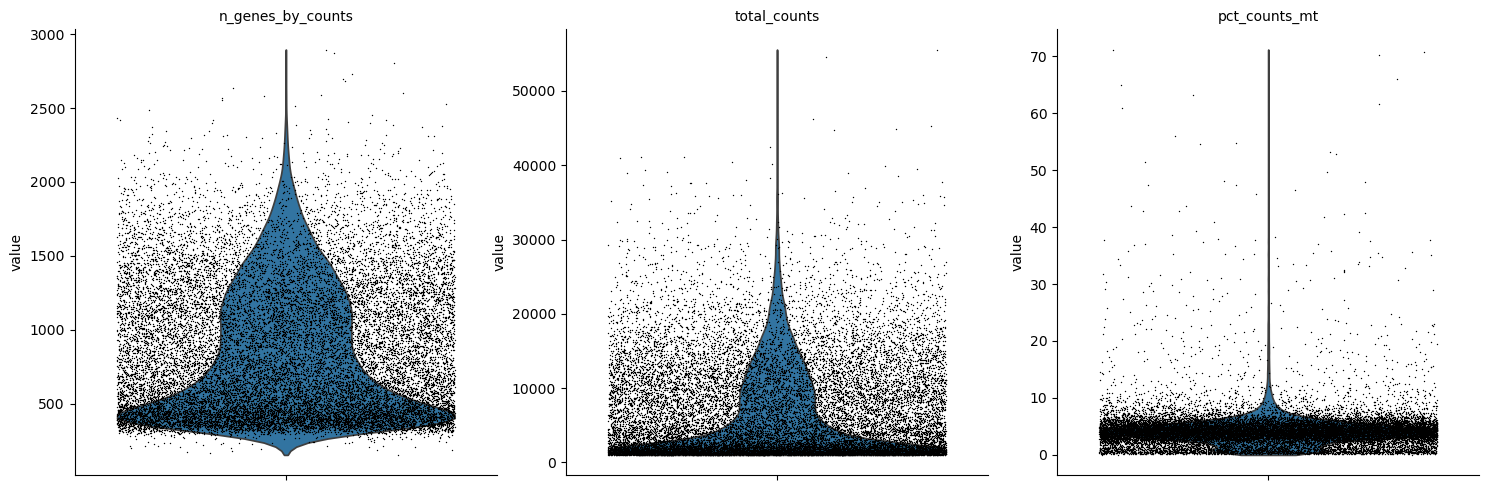

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

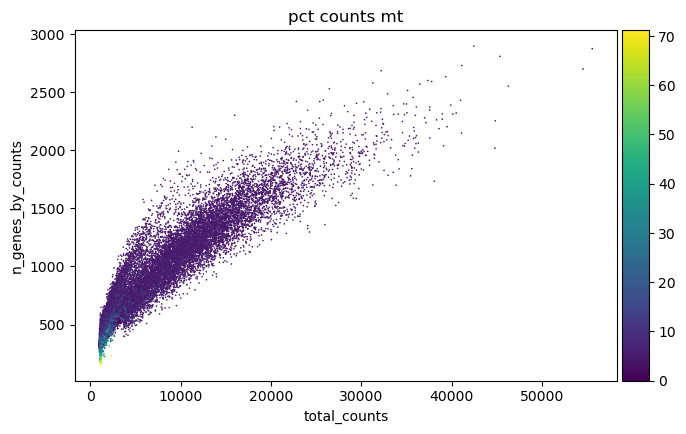

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## plot QC plot after do filtering

In [9]:
# maximum percent.mt
max_percent_mt = 15

adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > max_percent_mt
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    21453
True       283
Name: count, dtype: int64

In [10]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500


adata.obs["genes_outlier"] = \
    (adata.obs.n_genes_by_counts < min_n_genes_by_counts) | \
    (adata.obs.n_genes_by_counts > max_n_genes_by_counts)
adata.obs.genes_outlier.value_counts()

genes_outlier
False    21722
True        14
Name: count, dtype: int64

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[
    (~adata.obs.mt_outlier) & \
    (~adata.obs.genes_outlier)
].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 21736
Number of cells after filtering of low quality cells: 21439


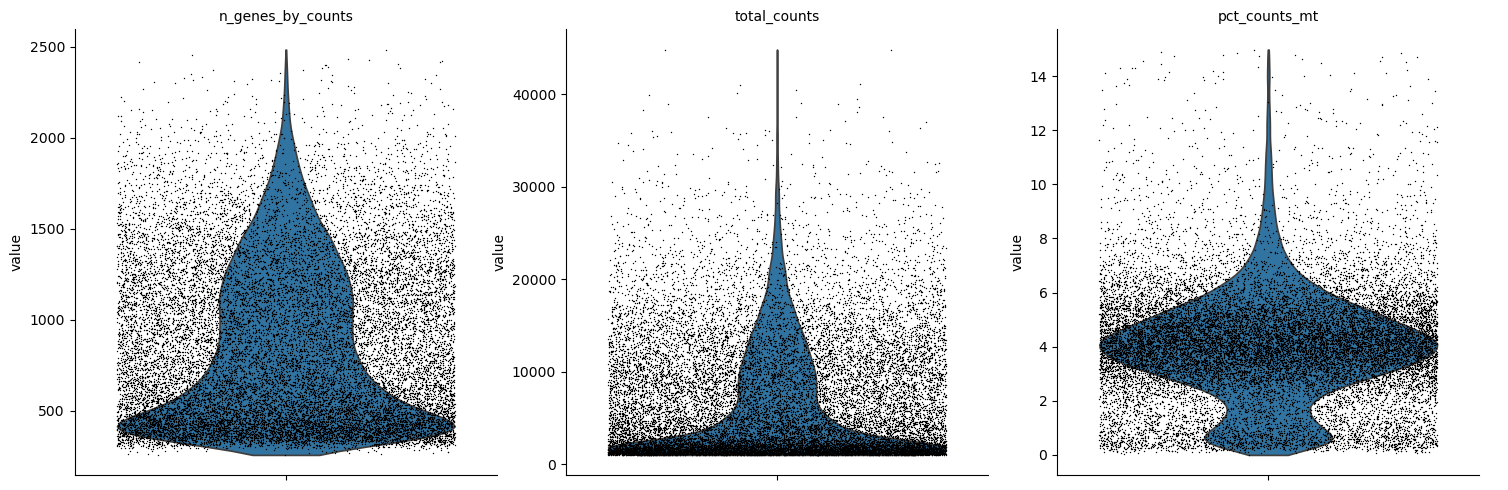

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

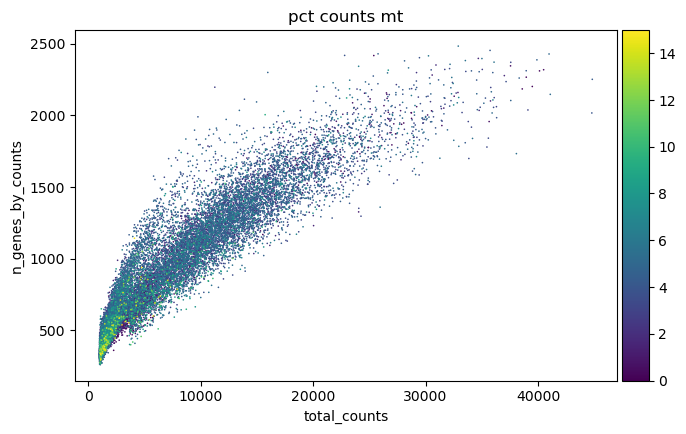

In [13]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [14]:
adata.obs.n_genes_by_counts.median()

np.float64(751.0)

In [15]:
adata.obs.total_counts.median()

np.float32(4299.0)

## write QC data for doublets check

In [16]:
if not os.path.exists('1.QC_mtx'):
    os.mkdir('1.QC_mtx')
adata.var['gene_ids'].to_csv('./1.QC_mtx/genes.tsv', sep='\t', header=False)
pd.DataFrame(adata.obs_names).to_csv('./1.QC_mtx/barcodes.tsv', sep='\t', header=False, index=False)
scipy.io.mmwrite('./1.QC_mtx/matrix.mtx', adata.X.T)

## remove doublets

In [16]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 21439 × 11801
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_858', 'DF.classifications_0.25_0.09_858'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [17]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

View of AnnData object with n_obs × n_vars = 20581 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## save AnnData after QC

In [18]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 20581 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'